# 0. IMPORTS

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor

from boruta import BorutaPy

import pickle

In [2]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [24, 24]
    plt.rcParams['font.size'] = 5

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()
    jupyter_settings()
    
sns.set(rc={'figure.figsize':(12,8)})

## data load

In [3]:
#dados obtidos via kaggle 
df1 = pd.read_csv('datasets/Rossmann/train.csv', low_memory=False)
df2 = pd.read_csv('datasets/Rossmann/store.csv')

In [4]:
df = pd.merge(df1,df2,how='left',on='Store')

In [5]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
df2.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1. DATA PROCESSING

## 1.1 Data clean

In [8]:
shape=df.shape
print('--o dataset contem--\nlinhas = {} \ncolunas = {}'.format(shape[0],shape[1]))

--o dataset contem--
linhas = 1017209 
colunas = 18


In [9]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
cols_old=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))

#renomear colunas
df.columns = cols_new
df.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [11]:
#Date = object
df['date'] = pd.to_datetime(df['date'])
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.2 Check NA

In [12]:
df.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [13]:
##competition_distance - distance in meters to the nearest competitor store
#df['competition_distance']= df['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x)
#                                                             else x )


#competition_open_since_month
#df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month'])
#                                              else x['competition_open_since_month'],axis=1)



 
##competition_open_since_year
#df['competition_open_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
#                                              else x['competition_open_since_year'],axis=1)


#promo2_since_week 
#df['promo2_since_week'] = df.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
#                                              else x['promo2_since_week'],axis=1)




#promo2_since_year
#df['promo2_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
#                                             else x['promo2_since_year'],axis=1)




#promo_interval
#df['promo_interval'].fillna(0,inplace=True)

#month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

#df['month_map'] = df['date'].dt.month.map(month_map)




#df['is_promo']= df[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis=1)




#with open('pickle_rossmann/df.pkl','wb') as arquivo:
#    pickle.dump(df,arquivo)


with open('pickle_rossmann/df.pkl','rb') as arquivo:
    df = pickle.load(arquivo)
    
df.isna().sum()


store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [14]:

df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df['competition_open_since_month'] = df['competition_open_since_month'].astype('int64')
df['competition_open_since_year'] = df['competition_open_since_year'].astype('int64')
df['promo2_since_week'] = df['promo2_since_week'].astype('int64')
df['promo2_since_year'] = df['promo2_since_year'].astype('int64')
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.3 Descriptive Statistical

In [16]:
num_attributes = df.select_dtypes(include=['int64','float64'])
cat_attributes = df.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.3.1 Numerical Attributes

In [17]:
#medidas tendencia central - mean,median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#medidas de dispersão - std,skew,kurtosis,min,max,range

ct3 = pd.DataFrame(num_attributes.apply( np.std ) ).T
ct4 = pd.DataFrame(num_attributes.apply( min ) ).T
ct5 = pd.DataFrame(num_attributes.apply( max ) ).T
ct6 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
ct7 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T
ct8 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() ) ).T

#concatenate

metrics = pd.concat([ct4,ct5,ct8,ct1,ct2,ct3,ct7,ct6]).T.reset_index()
metrics.columns = ['attributes','min','max','range','mean','median','std','kurtosis','skew']
metrics

,attributes,min,max,range,mean,median,std,kurtosis,skew
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-1.200524,-0.000955
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,-1.246873,0.001593
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,1.778375,0.641460
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,7.091773,1.598650
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,1.090723,-1.758045
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,-1.762018,0.487838
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,0.815154,1.677842
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,147.789712,10.242344
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-1.232607,-0.042076
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,124.071304,-7.235657


### 1.3.1 Categorical Attributes

In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

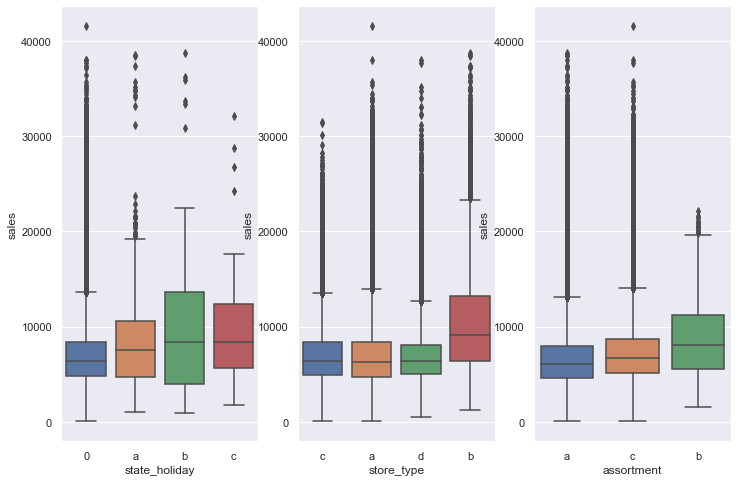

In [19]:
aux1 = df[(df['state_holiday']!=0)&(df['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)



# 2. FEATURE ENGINEERING

In [20]:
df2 = df.copy()

## 2.1 MAPA MIND DE HIPOTESES DO FENÔMENO

![image](https://drive.google.com/uc?export=view&id=14a2g6DayjCtio04cLgUYcPltNdLN92in)

## 2.2 CRIAÇÃO DE HIPOTESES

### TEMPORAL

1 - LOJA VENDE MENOS NO FIM DE SEMANA

2 - LOJA VENDE MAIS NO FERIADO DE NATAL

3 - LOJA VENDE MAIS NO FINAL DO ANO

4- LOJA VENDE MAIS DEPOIS DO DIA 10 DO MES



### LOJA
5 - LOJAS PERTO DE ESCOLAS VENDEM MENOS

6 - LOJA VENDE MENOS COM CONCORRENCIA PRÓXIMA

7 - LOJA COM MAIS VARIEDADE VENDE MAIS

8 - LOJA COM CONCORRENCIA POR MAIS TEMPO VENDE MAIS



### PRODUTOS


9- LOJA COM PRECOS MENORES COM MAIS TEMPO VENDE MAIS  

10 - LOJA COM PROMOCOES CONSECUTIVAS VENDE MAIS 



## 2.3 DERIVAR VARIAVEIS

In [21]:
##day
#df2['day'] = df2['date'].dt.day
##weekofyear
#df2['week_of_year'] = df2['date'].dt.weekofyear
##yearweek
#df2['year_week'] = df2['date'].dt.strftime('%Y-%M')
##year
#df2['year'] = df2['date'].dt.year
##month
#df2['month'] = df2['date'].dt.month



#competition_since
#df2['competition_since']= df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
#df2['competition_time_month']= ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

#promo_since
#df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
#df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w')-datetime.timedelta(days=7))
#df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')


##assortment
#df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')
##state_holiday
#df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x== 'a' else 'easter_holiday' if x=='b' else 'xmas_holiday' if x=='c' else 'regular_day')

#df2['competition_time_month'] = df2['competition_time_month'].astype('int64')
#df2['promo_time_week'] = df2['promo_time_week'].astype('int64')

#with open('pickle_rossmann/df2.pkl','wb') as arquivo:
#    pickle.dump(df2,arquivo)
    
with open("pickle_rossmann/df2.pkl","rb") as arquivo:
    df2 = pickle.load(arquivo)
    
    

In [22]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,day,week_of_year,year_week,year,month,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,31,31,2015-00,2015,7,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,31,31,2015-00,2015,7,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,31,31,2015-00,2015,7,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,31,31,2015-00,2015,7,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,31,31,2015-00,2015,7,2015-04-01,4,2015-07-27,0


## 2.4 FILTRAR VARIAVEIS

In [23]:
df3 = df2.loc[(df2['sales']>0)&(df2['open']==1)]
df3 = df3.drop(columns=['customers', 'open','promo_interval','month_map'])
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,day,week_of_year,year_week,year,month,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,31,31,2015-00,2015,7,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,31,31,2015-00,2015,7,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,31,31,2015-00,2015,7,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,31,31,2015-00,2015,7,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,31,31,2015-00,2015,7,2015-04-01,4,2015-07-27,0


# 3. EXPLORATORY DATA ANALYSIS

## 3.1 Reponse variable



C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

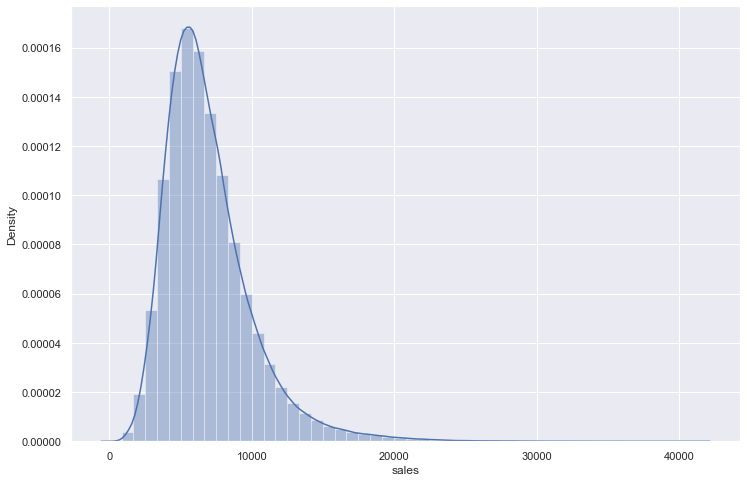

In [24]:
sns.distplot(df3['sales'],kde=True)

C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

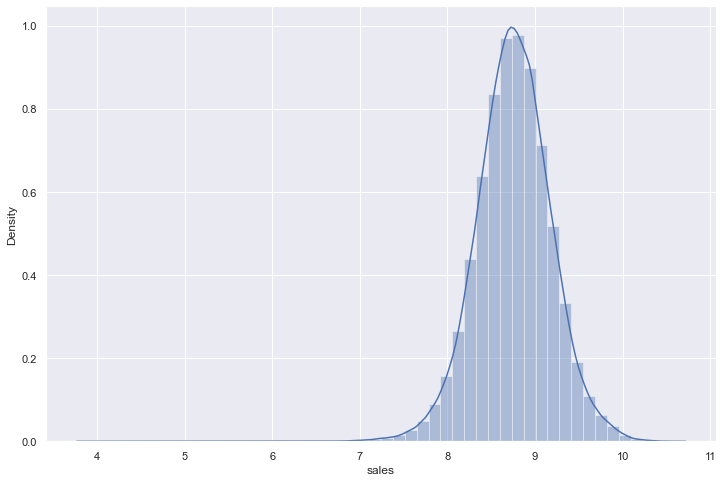

In [25]:
sns.distplot(np.log1p(df3['sales']))



## 3.2 Analise univariada


In [26]:
num_attributes_new = df3.select_dtypes(include=['int64','float64'])
cat_attributes_new = df3.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 3.2.1 numerical variables


array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

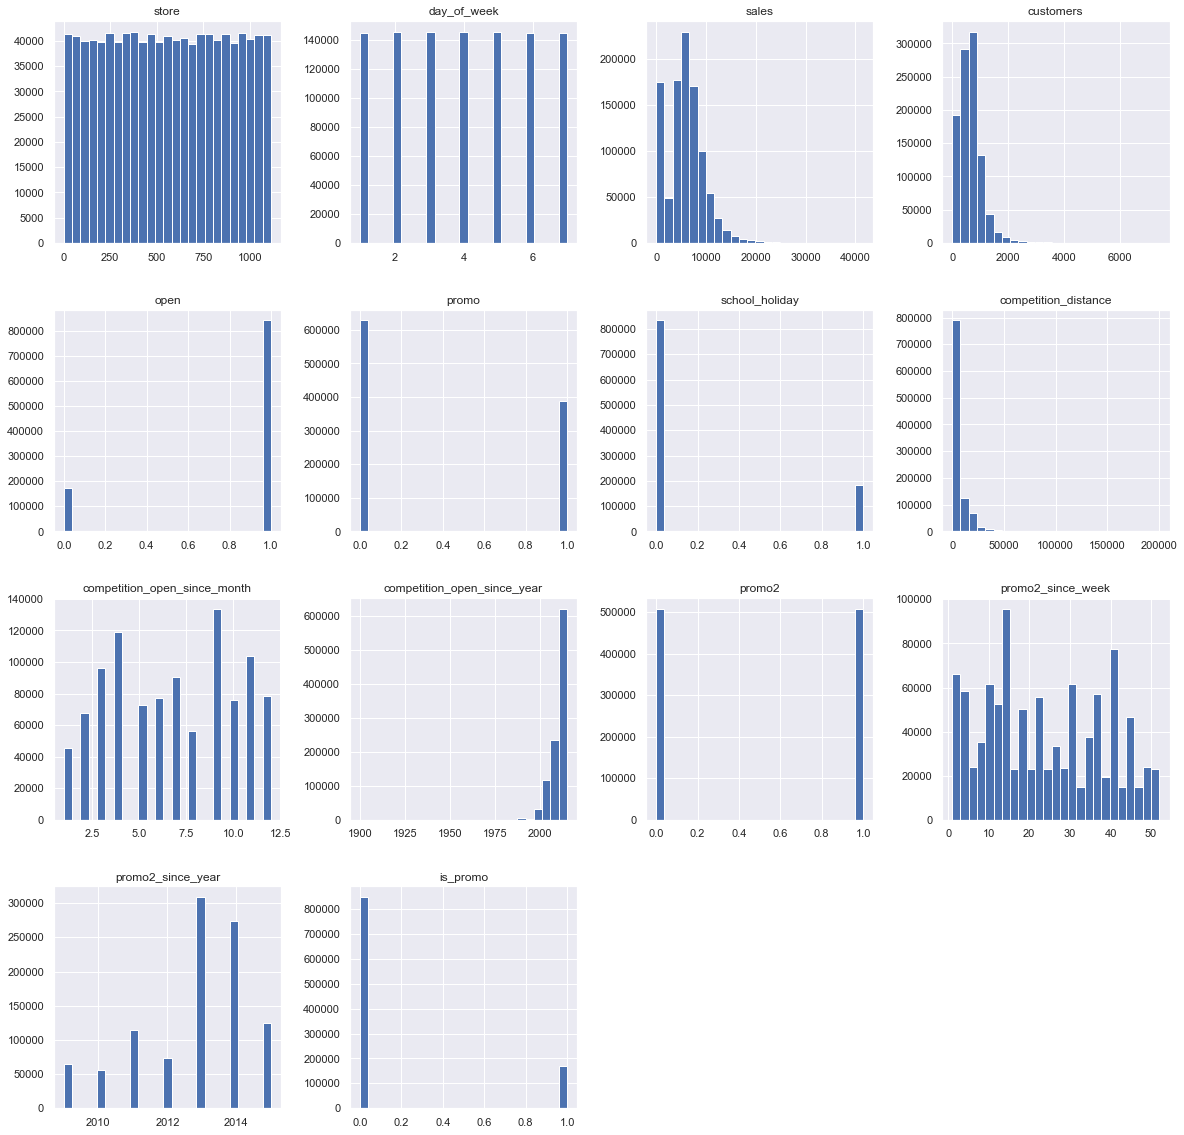

In [27]:
num_attributes.hist(bins=25,figsize=(20,20))

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'promo'}>],
       [<AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>,
        <AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>],
       [<AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>,
        <AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>],
       [<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'week_of_year'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'competition_time_month'}>,
        <AxesSubplot:title={'center':'promo_time_week'}>

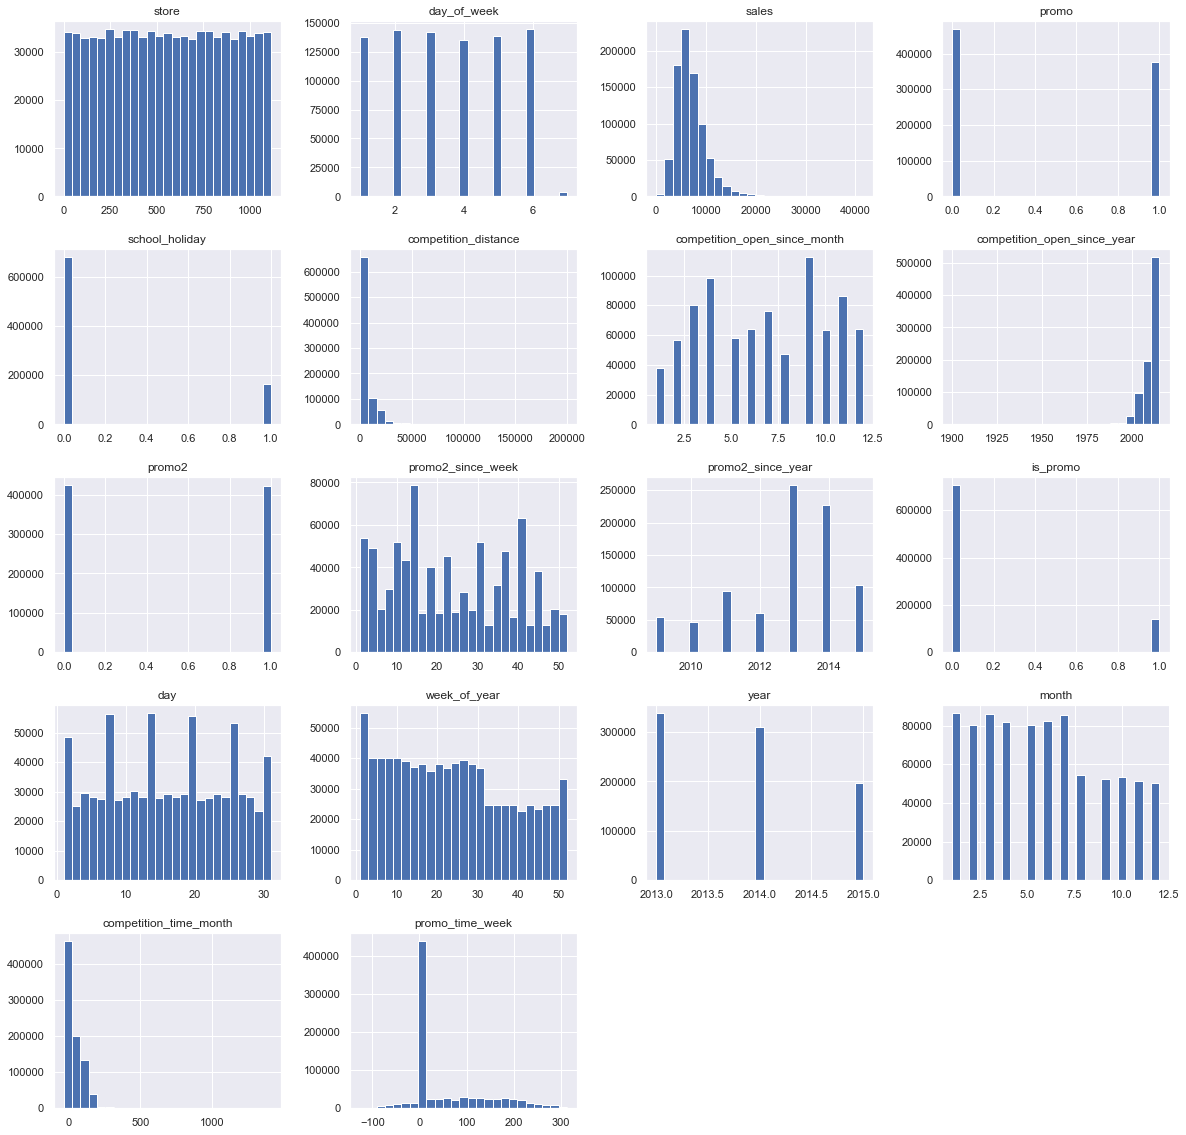

In [28]:
num_attributes_new.hist(bins=25,figsize=(20,20))

In [29]:
##Não faz diferença = dayofweek, promo2
## Não importa o dia da semana, a loja sempre tende a vender
## aparentemente, sem promoção a loja tende a vender mais **
##Sem feriado escolar = + vendas
##Lojas com competidores próximos tendem a vender mais
##

### 3.2.2 categorical variables
countplot + kdeplot
verificar dependencias ( se os feriados tem importancia nas vendas

In [30]:
cat_attributes_new.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-00
1,regular_day,a,basic,2015-00
2,regular_day,a,basic,2015-00
3,regular_day,c,extended,2015-00
4,regular_day,a,basic,2015-00


In [31]:
df3['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126      xmas_holiday
Name: state_holiday, dtype: object

In [32]:
df3['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

In [33]:
df3['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

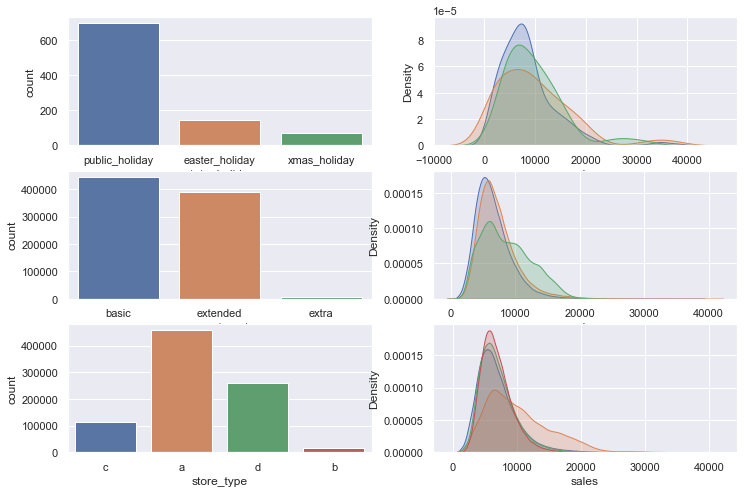

In [34]:
#state holiday study
plt.subplot(3,2,1)
aux = df3.loc[df3['state_holiday']!='regular_day']
sns.countplot(data=aux,x='state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(aux[aux['state_holiday']=='public_holiday']['sales'],label='public_holiday',shade=True)
sns.kdeplot(aux[aux['state_holiday']=='easter_holiday']['sales'],label='easter_holiday',shade=True)
sns.kdeplot(aux[aux['state_holiday']=='xmas_holiday']['sales'],label='xmas_holiday',shade=True)

#assortment study
plt.subplot(3,2,3)
sns.countplot(data=df3,x='assortment')

plt.subplot(3,2,4)
sns.kdeplot(df3[df3['assortment']=='basic']['sales'],label='basic',shade=True)
sns.kdeplot(df3[df3['assortment']=='extended']['sales'],label='extended',shade=True)
sns.kdeplot(df3[df3['assortment']=='extra']['sales'],label='extra',shade=True)

#store type study
plt.subplot(3,2,5)
sns.countplot(data=df3,x='store_type')

plt.subplot(3,2,6)
sns.kdeplot(df3[df3['store_type']=='a']['sales'],label='a',shade=True)
sns.kdeplot(df3[df3['store_type']=='b']['sales'],label='b',shade=True)
sns.kdeplot(df3[df3['store_type']=='c']['sales'],label='c',shade=True)
sns.kdeplot(df3[df3['store_type']=='d']['sales'],label='d',shade=True)
                  


## 3.3 Analise bivariada



### 3.3.1 LOJA VENDE MENOS NO FIM DE SEMANA ->TRUE


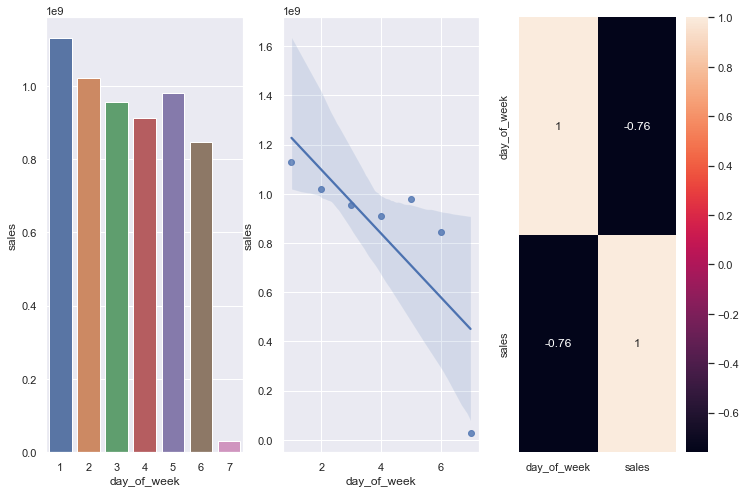

In [35]:
aux = df3[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(data=aux,x='day_of_week',y='sales');

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux);

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'),annot=True);

* As vendas tendem a diminuir com o decorrer da semana visto que, domingo a loja se encontra fechada.

### 3.3.2  LOJA VENDE MAIS NO FERIADO DE NATAL -> FALSE

<AxesSubplot:xlabel='year', ylabel='sales'>

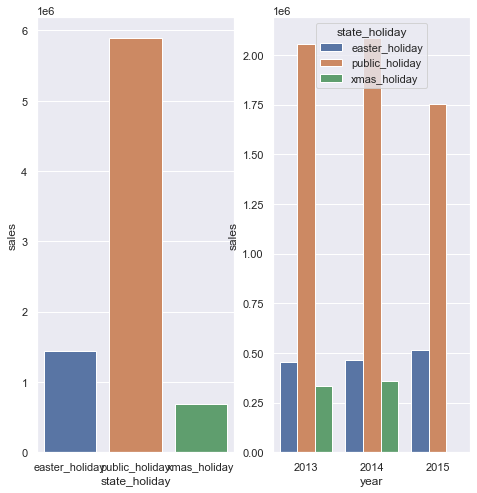

In [36]:
aux = df3.loc[df3['state_holiday']!='regular_day',['sales','state_holiday','year']]
aux2 = aux.groupby('state_holiday').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='state_holiday',y='sales',data=aux2)

plt.subplot(1,3,2)
aux3 = aux.groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux3)



* Public holiday vende mais talvez pelo fato de ter mais dias de public holiday

### 3.3.3 LOJA VENDE MAIS NO FINAL DO ANO -> FALSE



<AxesSubplot:>

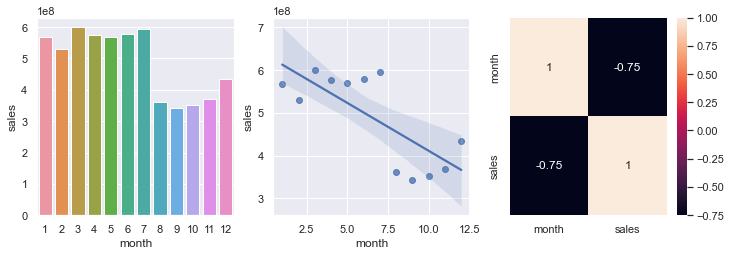

In [37]:
aux = df3[['sales','month']].groupby('month').sum().reset_index()

plt.subplot(2,3,1)
sns.barplot(x='month',y='sales',data=aux)

plt.subplot(2,3,2)
sns.regplot(x='month',y='sales',data=aux)

plt.subplot(2,3,3)
sns.heatmap(aux.corr(method='pearson'),annot=True)






* Após o mês 6 há um decaimento bastante expressivo nas vendas

### 3.3.4  LOJA VENDE MAIS DEPOIS DO DIA 10 DO MES -> TRUE

<AxesSubplot:>

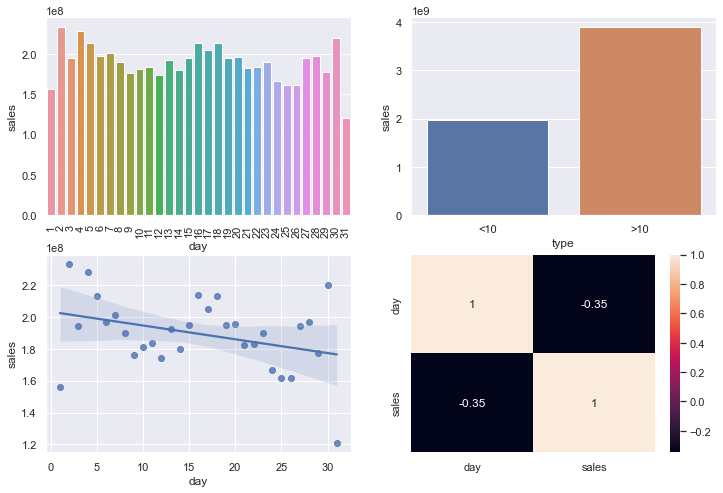

In [38]:
aux = df3[['sales','day']].groupby('day').sum().reset_index()
aux['type'] = aux.apply(lambda x: '<10' if x['day'] <= 10 else '>10',axis=1)
aux2 = aux[['sales','type']].groupby('type').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux)
plt.xticks(rotation=90)


plt.subplot(2,2,2)
sns.barplot(x='type',y='sales',data=aux2)

plt.subplot(2,2,3)
sns.regplot(x='day',y='sales',data=aux)

plt.subplot(2,2,4)
sns.heatmap(aux.corr(method='pearson'),annot=True)

* Lojas tendem a vender menos após o dia 10, mas como temos muito mais dias pra analisar, a somatória deu maior! 

### 3.3.5 LOJA VENDE MENOS PERTO DE ESCOLAS -> TRUE

<AxesSubplot:xlabel='month', ylabel='sales'>

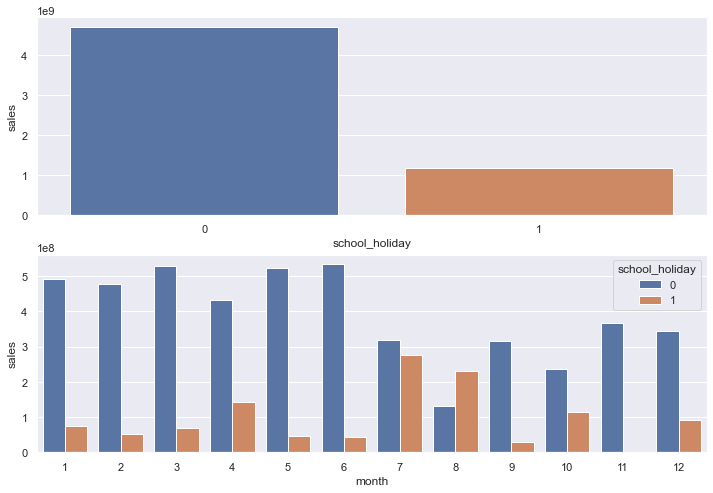

In [39]:
aux = df3[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
aux2 = df3[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales',data=aux)

plt.subplot(2,1,2)
sns.barplot(x='month',y='sales',data=aux2,hue='school_holiday')



* Mes 7 e 8 há um comportamento diferente, as vendas se equiparam .

### 3.3.6 LOJA VENDE MENOS COM CONCORRENCIA PRÓXIMA -> FALSE


<AxesSubplot:>

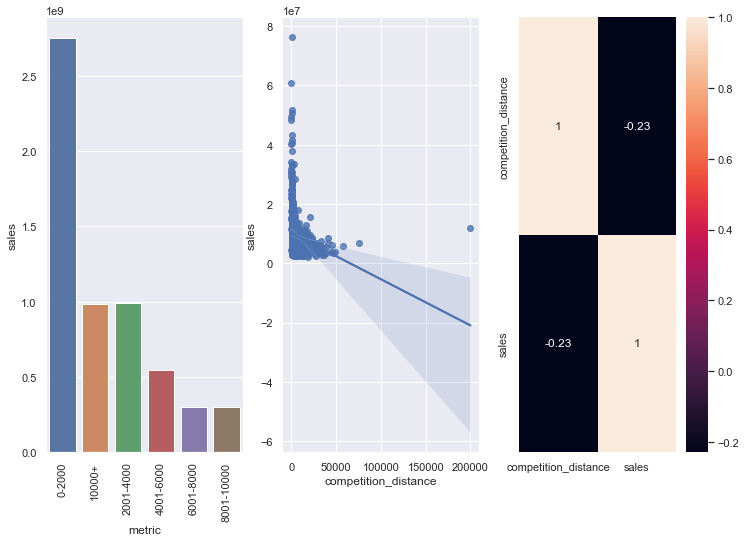

In [40]:
aux = df3[['sales','competition_distance']].groupby('competition_distance').sum().reset_index()
aux['competition_distance'] = aux['competition_distance'].astype(int)
aux['metric'] = aux.apply(lambda x: '0-2000' if  x['competition_distance']<=2000 else 
                          '2001-4000' if 2000<x['competition_distance']<=4000 else
                          '4001-6000' if 4000<x['competition_distance']<=6000 else
                          '6001-8000'if 6000<x['competition_distance']<=8000 else 
                          '8001-10000' if 8000<x['competition_distance']<=10000 else
                          '10000+',axis=1)

aux2=aux[['metric','sales']].groupby('metric').sum().reset_index()
aux2 =aux2.sort_values(by='metric')

plt.subplot(1,3,1)
sns.barplot(x='metric',y='sales',data=aux2)
plt.xticks(rotation=90)


plt.subplot(1,3,2)
sns.regplot(x='competition_distance',y='sales',data=aux)

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'),annot=True)


* Lojas vendem mais com concorrência próxima!

### 3.3.7 LOJA COM MAIS VARIEDADE VENDE MAIS -> TRUE

<AxesSubplot:xlabel='month', ylabel='sales'>

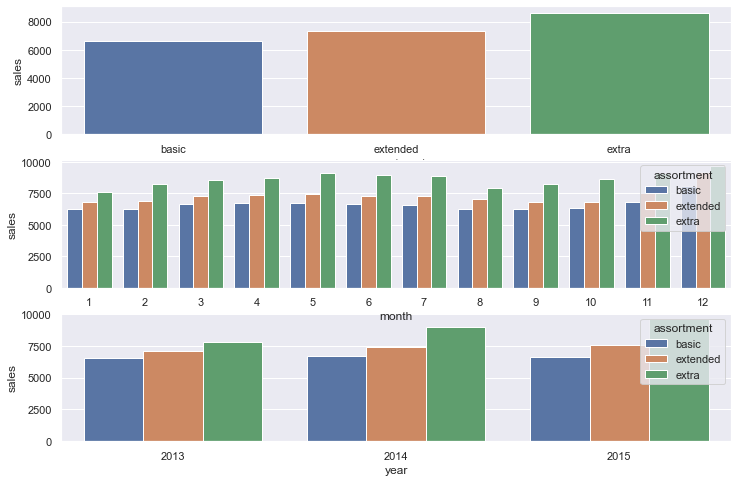

In [41]:
aux = df3 [['assortment','sales']].groupby('assortment').mean().reset_index()


plt.subplot(3,1,1)
sns.barplot(x='assortment',y='sales',data=aux)

plt.subplot(3,1,3)
aux2 = df3[['assortment','sales','year']].groupby(['year','assortment']).mean().reset_index()
sns.barplot(x='year',y='sales',hue='assortment',data=aux2)

plt.subplot(3,1,2)
aux3 = df3 [['assortment','month','sales']].groupby(['month','assortment']).mean().reset_index()
sns.barplot(x='month',y='sales',hue='assortment',data=aux3)




* Em todos os meses as lojas com o tipo extra de assortment vendem mais na média.

### 3.3.8  LOJA COM CONCORRENCIA POR MAIS TEMPO VENDE MAIS -> FALSE

In [42]:
aux = df3[['sales','competition_time_month']].groupby('competition_time_month').sum().reset_index()
aux['competition_time_month'].describe()

count     376.000000
mean      262.500000
std       355.700541
min       -32.000000
25%        61.750000
50%       155.500000
75%       250.250000
max      1407.000000
Name: competition_time_month, dtype: float64

<AxesSubplot:>

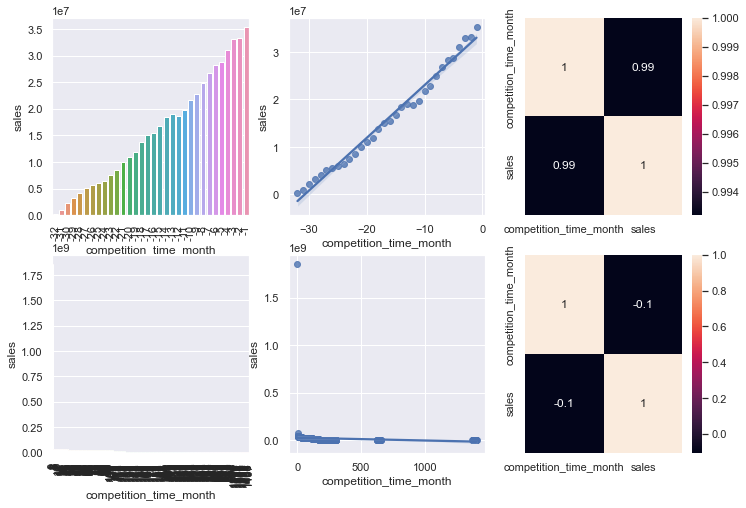

In [43]:
#LOJAS QUE IRÃO TER COMPETIÇÃO
aux2 = aux.loc[aux['competition_time_month']<0]


plt.subplot(2,3,1)
sns.barplot(x='competition_time_month',y='sales',data=aux2)
plt.xticks(rotation=90);

plt.subplot(2,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux2)

plt.subplot(2,3,3)
sns.heatmap(aux2.corr(method='pearson'),annot=True)

#LOJAS COM COMPETIÇÃO 
aux3 = aux.loc[aux['competition_time_month']>=0]

plt.subplot(2,3,4)
sns.barplot(x='competition_time_month',y='sales',data=aux3)
plt.xticks(rotation=90);

plt.subplot(2,3,5)
sns.regplot(x='competition_time_month',y='sales',data=aux3)

plt.subplot(2,3,6)
sns.heatmap(aux3.corr(method='pearson'),annot=True)


* Lojas que irão ter concorrencia tendem a vender mais, talvez pelo fato de um competidor aquecer o mercado

### 3.3.9 LOJA COM PROMOCAO A MAIS TEMPO VENDE MAIS -> FALSE



In [44]:
aux1=df3[['sales','promo_time_week']].groupby('promo_time_week').sum().reset_index()
aux1

##promo_time_week > 0 -> loja com promocao ativa
##promo_time_week < 0 -> Loja que vai abrir promocao ( quanto mais próximo de 0, mais perto ela está de abrir promoção)

,promo_time_week,sales
0,-126,80706
1,-125,147212
2,-124,107127
3,-123,140121
4,-122,116593
...,...,...
435,309,360433
436,310,277156
437,311,353546
438,312,268970


<AxesSubplot:xlabel='promo_time_week', ylabel='sales'>

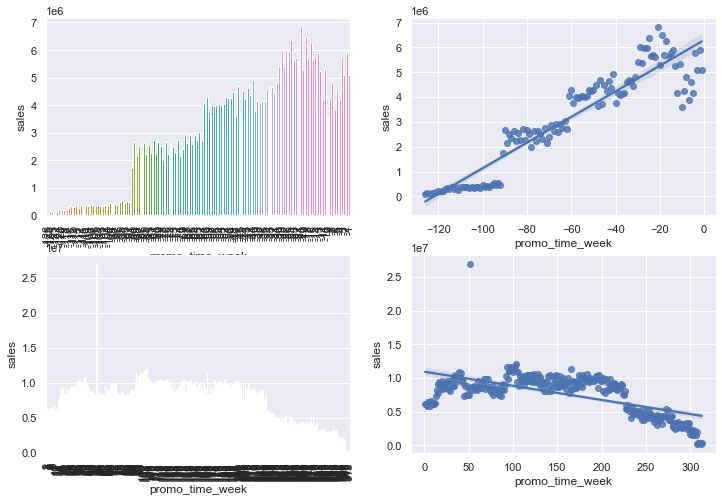

In [45]:

aux2 = aux1.loc[aux1['promo_time_week']<0]
aux3 = aux1.loc[aux1['promo_time_week']>0]

plt.subplot(2,2,1)
sns.barplot(x='promo_time_week',y='sales',data=aux2)
plt.xticks(rotation=90);


plt.subplot(2,2,2)
sns.regplot(x='promo_time_week',y='sales',data=aux2)

plt.subplot(2,2,3)
sns.barplot(x='promo_time_week',y='sales',data=aux3)
plt.xticks(rotation=90);

plt.subplot(2,2,4)
sns.regplot(x='promo_time_week',y='sales',data=aux3)


* lojas que irão ter promoção vendem mais, porém depois de um longo período de promoção, as vendas decaem

### 3.3.10 LOJA COM PROMOCOES CONSECUTIVAS VENDE MAIS -> FALSE

In [46]:
df3[['promo2','promo','sales']].groupby(['promo','promo2']).sum().reset_index()

## as menores vendas foram das lojas que possuem participação na promoção2
## portanto a promo2 não é uma boa opção de negócio!

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


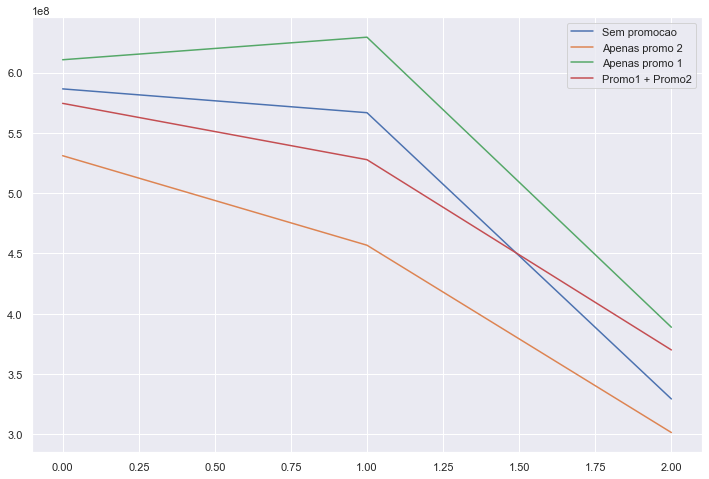

In [47]:
aux = df3[['promo2','promo','sales','year_week']]
aux2 = aux[(aux['promo']==0)&(aux['promo2']==0)][['sales','year_week']].groupby('year_week').sum().reset_index()
ax = aux2.plot()

aux3 = aux[(aux['promo']==0)&(aux['promo2']==1)][['sales','year_week']].groupby('year_week').sum().reset_index()
ax2 = aux3.plot(ax=ax)

aux4 = aux[(aux['promo']==1)&(aux['promo2']==0)][['sales','year_week']].groupby('year_week').sum().reset_index()
ax3 = aux4.plot(ax=ax2)

aux5 = aux[(aux['promo']==1)&(aux['promo2']==1)][['sales','year_week']].groupby('year_week').sum().reset_index()
aux5.plot(ax=ax3)
ax.legend(labels=['Sem promocao','Apenas promo 2','Apenas promo 1','Promo1 + Promo2'])



* Lojas com promo2 tendem a diminuir vendas!

## 3.4 Analise multivariada



### 3.4.1 Variáveis Numéricas

<AxesSubplot:>

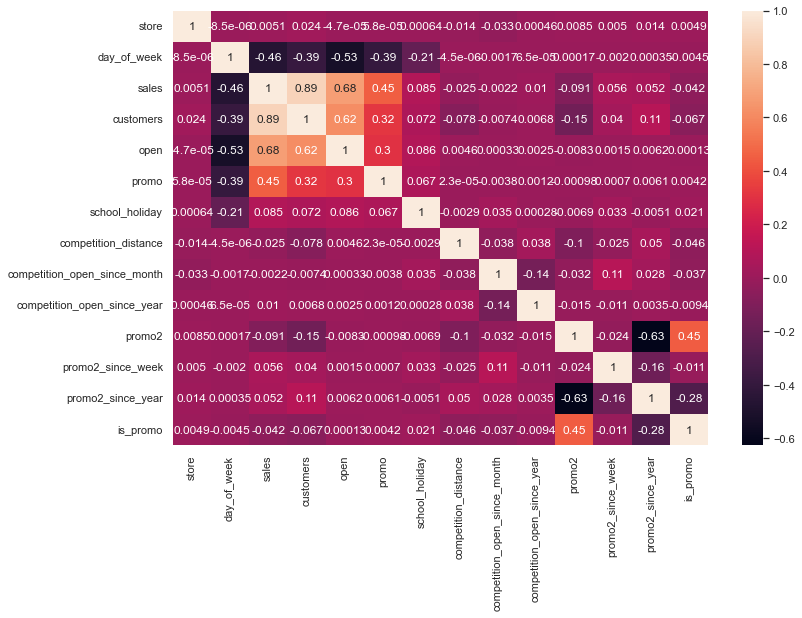

In [48]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True)

### 3.4.2 Variáveis Categóricas

In [49]:
from scipy import stats as ss

In [50]:
#renovar as variaveis categoricas
cat = df3.select_dtypes(include='object')
cat.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-00
1,regular_day,a,basic,2015-00
2,regular_day,a,basic,2015-00
3,regular_day,c,extended,2015-00
4,regular_day,a,basic,2015-00


In [51]:
# função pra calcular a correlação de variaveis categóricas
def cramer_v(x,y):
    #criar um matriz entre as variaveis categoricas
    a = pd.crosstab(x,y)
    cm = a.to_numpy()
    
    #modelagem do método V-CRAMER
    n=cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0] ##posição 0 -> correlação 
    
    #correção do BIAS
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
   
    
    v = np.sqrt ( (chi2corr/n) / (min(kcorr-1,rcorr-1) ) )
    return v 

In [52]:
a1 = cramer_v(cat['state_holiday'],cat['state_holiday'])
a2 = cramer_v(cat['state_holiday'],cat['store_type'])
a3 = cramer_v(cat['state_holiday'],cat['assortment'])

a4 = cramer_v(cat['store_type'],cat['state_holiday'])
a5 = cramer_v(cat['store_type'],cat['store_type'])
a6 = cramer_v(cat['store_type'],cat['assortment'])

a7 = cramer_v(cat['assortment'],cat['state_holiday'])
a8 = cramer_v(cat['assortment'],cat['store_type'])
a9 = cramer_v(cat['assortment'],cat['assortment'])

d = pd.DataFrame ( {'state_holiday':[a1,a2,a3],
                'store_type':[a4,a5,a6],
                'assortment':[a7,a8,a9]})

d= d.set_index(d.columns)
d


,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

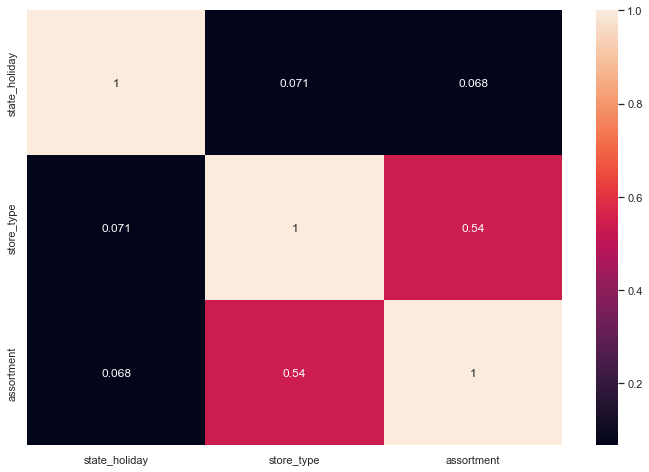

In [53]:
sns.heatmap(d,annot=True)

# 4. DATA PREPARATION



In [54]:
df4 = df3.copy()

## 4.1 Normalização

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

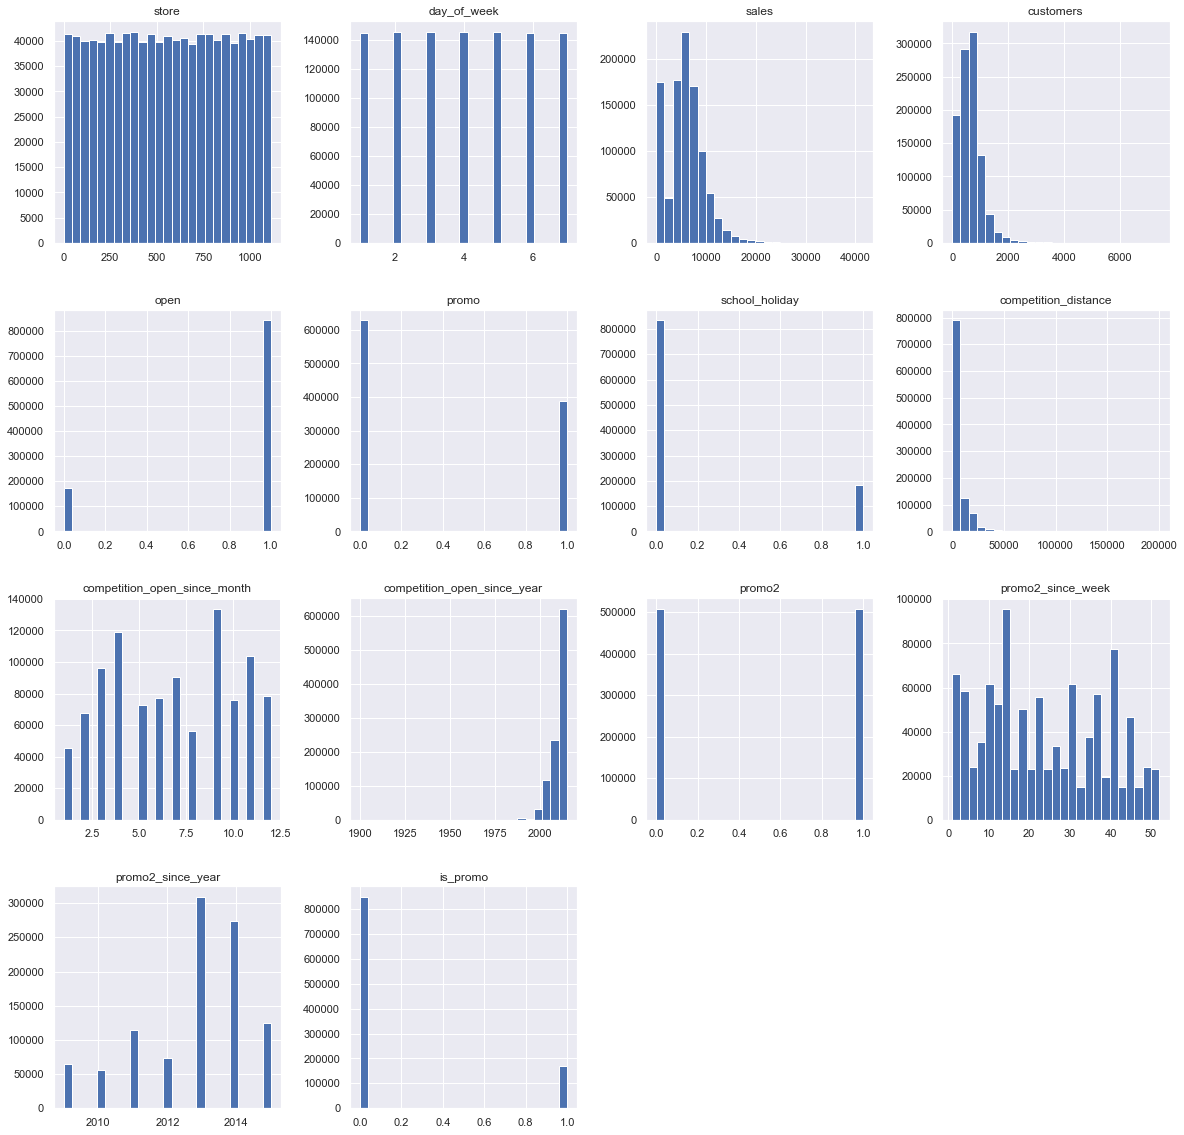

In [55]:
num_attributes.hist(bins=25,figsize=(20,20))

## 4.2 Rescale

### 4.2.1 Select features

In [56]:
a = df4.select_dtypes(include=['int64','float64'])
b = df4.select_dtypes(include=['object'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,day,week_of_year,year,month,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,31,31,2015,7,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,31,31,2015,7,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,31,31,2015,7,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,31,31,2015,7,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,31,31,2015,7,4,0


C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Daniel\anaconda3\li

<AxesSubplot:xlabel='promo_time_week'>

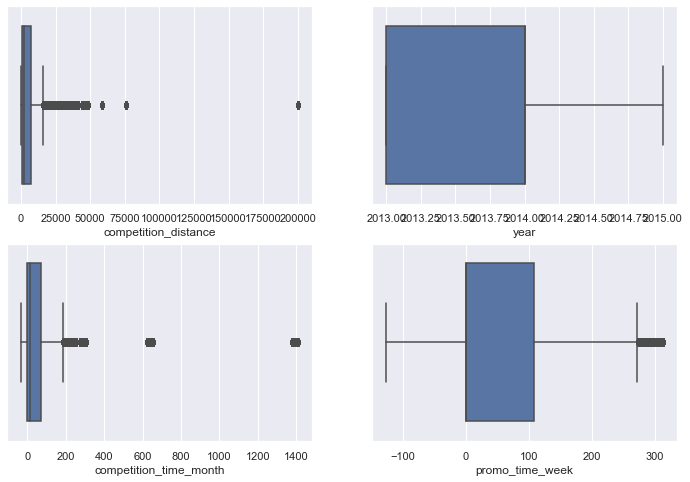

In [57]:
# ----- NATUREZA CÍCLICA-------
#month
#day
#weekofyear
#day_of_week

#--------CHECAR OUTLIERS-------
#competition_distance 
plt.subplot(2,2,1)
sns.boxplot(df4['competition_distance'])
#year
plt.subplot(2,2,2)
sns.boxplot(df4['year'])
#competition_time_month
plt.subplot(2,2,3)
sns.boxplot(df4['competition_time_month'])
#promo_time_week
plt.subplot(2,2,4)
sns.boxplot(df4['promo_time_week'])


### 4.2.2 Robust Scaler 

In [58]:
##tende a ser viável em variaveis com outliers expressivos
from sklearn.preprocessing import RobustScaler
rs= RobustScaler()

C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

<AxesSubplot:xlabel='competition_time_month', ylabel='Density'>

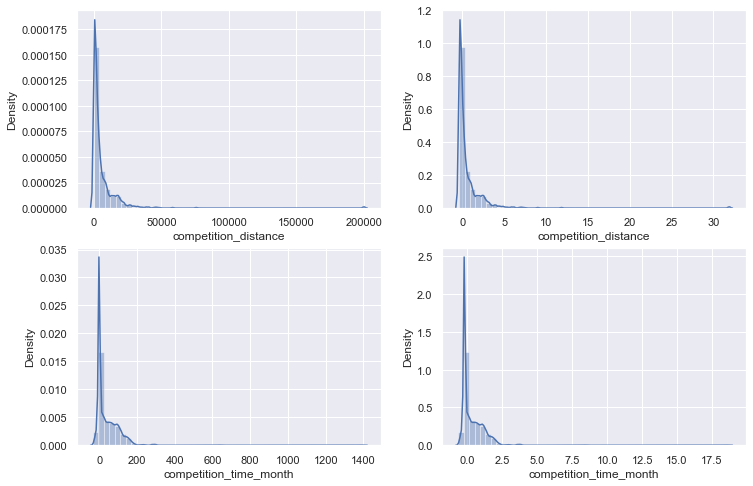

In [59]:
#competition_distance 
df4['competition_distance'] = rs.fit_transform(df4[['competition_distance']].values)


plt.subplot(2,2,1)##antes do robust
sns.distplot(df3['competition_distance'])

plt.subplot(2,2,2) ##após
sns.distplot(df4['competition_distance'])

#competition_time_month
df4['competition_time_month'] = rs.fit_transform(df4[['competition_time_month']].values)

plt.subplot(2,2,3)
sns.distplot(df3['competition_time_month'])

plt.subplot(2,2,4)
sns.distplot(df4['competition_time_month'])




### 4.2.3 MinMax Scaler


In [60]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

<AxesSubplot:xlabel='year', ylabel='Density'>

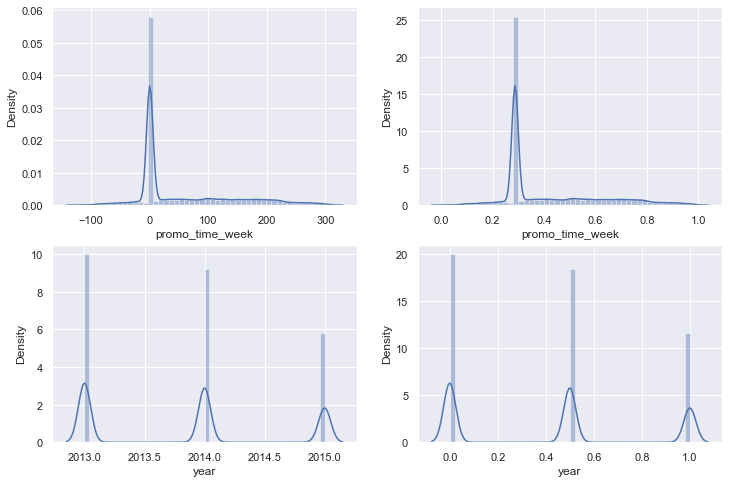

In [61]:
#promo_time_week
df4['promo_time_week'] = mms.fit_transform(df4[['promo_time_week']].values)

plt.subplot(2,2,1)
sns.distplot(df3['promo_time_week'])

plt.subplot(2,2,2)
sns.distplot(df4['promo_time_week'])


#year
df4['year'] = mms.fit_transform(df4[['year']].values)


plt.subplot(2,2,3)
sns.distplot(df3['year'])

plt.subplot(2,2,4)
sns.distplot(df4['year'])



## 4.3 Transformation

### 4.3.1 Encoding variaveis categóricas

In [62]:
b.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-00
1,regular_day,a,basic,2015-00
2,regular_day,a,basic,2015-00
3,regular_day,c,extended,2015-00
4,regular_day,a,basic,2015-00


In [63]:
#state_holiday -> one hot encoding -> cria colunas
df4 = pd.get_dummies(df4, prefix=['state_holiday'],columns=['state_holiday'])

#store_type -> sem ordem -> label encoding 
le = LabelEncoder()
df4['store_type'] = le.fit_transform(df4['store_type'])


#assortment -> ordinal encoder
a = {'basic':1,'extra':2,'extended':3}
df4['assortment'] = df4['assortment'].map(a)


### 4.3.2 Rescale das variaveis cíclicas

In [64]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'day',
       'week_of_year', 'year_week', 'year', 'month', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'state_holiday_xmas_holiday'],
      dtype='object')

In [65]:
#month
df4['month_sin'] = df4['month'].apply(lambda x: np.sin(x* (2.*np.pi/12 ) ) )
df4['month_cos'] = df4['month'].apply(lambda x: np.cos(x* (2.*np.pi/12 ) ) )
#day
df4['day_sin'] = df4['day'].apply(lambda x: np.sin(x* (2.*np.pi/12 ) ) )
df4['day_cos'] = df4['day'].apply(lambda x: np.cos(x* (2.*np.pi/12 ) ) )
#weekofyear
df4['weekofyear_sin'] = df4['week_of_year'].apply(lambda x: np.sin(x* (2.*np.pi/12 ) ) )
df4['weekofyear_cos'] = df4['week_of_year'].apply(lambda x: np.cos(x* (2.*np.pi/12 ) ) )

#day_of_week
df4['dayofweek_sin'] = df4['day_of_week'].apply(lambda x: np.sin(x* (2.*np.pi/12 ) ) )
df4['dayofweek_cos'] = df4['day_of_week'].apply(lambda x: np.cos(x* (2.*np.pi/12 ) ) )

### 4.3.3 Normalizar Variavel Resposta

In [66]:
df4['sales'] = np.log1p(df4['sales'])

C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

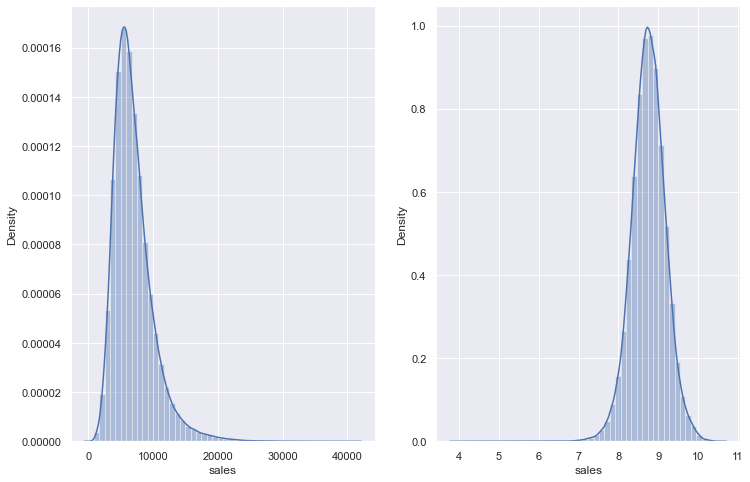

In [67]:
plt.subplot(1,2,1)
sns.distplot(df3['sales'])

plt.subplot(1,2,2)
sns.distplot(df4['sales'])

# 5. SELECT ATTRIBUTES


In [68]:
df5 = df4.copy()

In [69]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_regular_day,state_holiday_xmas_holiday,month_sin,month_cos,day_sin,day_cos,weekofyear_sin,weekofyear_cos,dayofweek_sin,dayofweek_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,1,0,-0.5,-0.866025,-0.5,-0.866025,-0.5,-0.866025,0.5,-0.866025
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,1,0,-0.5,-0.866025,-0.5,-0.866025,-0.5,-0.866025,0.5,-0.866025
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,1,0,-0.5,-0.866025,-0.5,-0.866025,-0.5,-0.866025,0.5,-0.866025
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,1,0,-0.5,-0.866025,-0.5,-0.866025,-0.5,-0.866025,0.5,-0.866025
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,1,0,-0.5,-0.866025,-0.5,-0.866025,-0.5,-0.866025,0.5,-0.866025


In [70]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df5 = df5.drop(cols_drop,axis=1)

## 5.1 Split dataframe into training and test

In [71]:
df5[['date','store']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=42)

Timestamp('2015-06-19 00:00:00')

In [72]:
#training dataset
X_train = df5[df5['date']<'2015-06-19']
Y_train = X_train['sales']

#test dataset
X_test = df5[df5['date']>='2015-06-19']
Y_test = X_test['sales']

print('Training min date: {}'.format(X_train['date'].min()))
print('Training max date: {}'.format(X_train['date'].max()))

print('Test min date: {}'.format(X_test['date'].min()))
print('Test max date: {}'.format(X_test['date'].max()))


Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00
Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## 5.2 Boruta as feature selector

In [73]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import pickle

In [ ]:
#training and test for boruta
cols_drop=['sales','date']
X_train_n = X_train.drop(cols_drop,axis=1).values
Y_train_n = Y_train.values.ravel()

#define random forest regressor
#rf = RandomForestRegressor(n_jobs=-1)

#define boruta
#boruta = BorutaPy( rf ,n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, Y_train_n)

    
with open('pickle_rossmann/boruta.pkl','rb') as arquivo:
    boruta=pickle.load(arquivo)


### 5.2.1 Best features BORUTA

In [ ]:

cols_selected = boruta.support_.tolist()

#best features
X_train_fs = X_train.drop(['date','sales'],axis=1)
cols_selected_boruta = list(X_train_fs.iloc[:,cols_selected])

#bad features
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns ,cols_selected_boruta))

In [ ]:
cols_selected_boruta

In [ ]:
cols_not_selected_boruta

# 6. MACHINE LEARNING ALGORITHMS



## 6.1 CROSS-VALIDATION

## 6.2 FINE TUNING